In [1]:
## DeepExplain - Keras (TF backend) example
### MNIST with CNN

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
import tensorflow as tf
import scipy

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

#Import DeepLift
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import compile_func


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Build and train a network.

SKIP_TRAIN = False
saved_model_file = 'model.h5'

batch_size = 128
num_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 4, 3

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.array([scipy.misc.imresize(x, (img_rows,img_cols,)) for x in x_train])
x_test = np.array([scipy.misc.imresize(x, (img_rows,img_cols,)) for x in x_test])



#x_train = x_train.reshape(-1, 28,28,1)
#x_test = x_test.reshape(-1, 28,28,1)
x_train = x_train.reshape(-1, img_rows*img_cols)
x_test = x_test.reshape(-1, img_rows*img_cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
reg = keras.regularizers.l1(0)
def f(x):
    return x*tf.sigmoid(x)

if SKIP_TRAIN:
    model = load_model(saved_model_file)
else:
    #de.enable_override('shapley')
    model = Sequential()
    #model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1)))
    #model.add(Conv2D(64, (3, 3), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))
    #model.add(Flatten())
    model.add(Dense(20, input_shape=(img_rows*img_cols,), activation='relu', bias_regularizer=reg))
    model.add(Dense(20, activation='relu', bias_regularizer=reg))
    model.add(Dense(20, activation='relu', bias_regularizer=reg))
    model.add(Dense(20, activation='relu', bias_regularizer=reg))
    model.add(Dense(num_classes, bias_regularizer=reg))
    model.add(Activation('softmax'))
    # ^ IMPORTANT: notice that the final softmax must be in its own layer 
    # if we want to target pre-softmax units

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    model.save(saved_model_file)
    print (model.layers[0].get_weights()[1].mean())
    print (model.layers[0].get_weights()[1].var())
    
#score = model.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


x_train shape: (60000, 12)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 29us/step - loss: 1.8435 - acc: 0.3243 - val_loss: 1.5450 - val_acc: 0.4529
Epoch 2/10
60000/60000 [==============================] - 1s 21us/step - loss: 1.1893 - acc: 0.5873 - val_loss: 0.9980 - val_acc: 0.6835
Epoch 3/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.9590 - acc: 0.6769 - val_loss: 0.9037 - val_acc: 0.7099
Epoch 4/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.8846 - acc: 0.7043 - val_loss: 0.8370 - val_acc: 0.7258
Epoch 5/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.8389 - acc: 0.7197 - val_loss: 0.8235 - val_acc: 0.7368
Epoch 6/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.8048 - acc: 0.7327 - val_loss: 0.7782 - val_acc: 0.7474
Epoch 7/10
60000/60000 [==============================] - 1s 2

In [4]:
%matplotlib inline
aModel = Model(inputs=model.inputs, outputs=[model.layers[1].input])
y = aModel.predict(x_test)
import matplotlib.pyplot as plt
#plt.hist(model.layers[1].get_weights()[0].flatten(), 100)
#plt.hist(y.flatten(), 100)

In [5]:
# Define what to be explained
xs = x_test[0:40]
ys = y_test[0:40]

In [6]:
# Compute DeepLift attributions
revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)
rescale_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.Rescale)

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
rescale_func = rescale_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

a_rc = np.array([np.array(revealcancel_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])

a_res = np.array([np.array(rescale_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])
print (a_rc.shape)

nonlinear_mxts_mode is set to: RevealCancel
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
nonlinear_mxts_mode is set to: Rescale
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
(40, 1, 12)


In [7]:
%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    

    
    a_gradin = de.explain('grad*input', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('saliency', target_tensor * ys, input_tensor, xs)
    a_intgrad = de.explain('intgrad', target_tensor * ys, input_tensor, xs)
    #a_res = de.explain('deeplift', target_tensor * ys, input_tensor, xs)
    #a_linear = de.explain('linear', target_tensor * ys, input_tensor, xs)
    a_shap = de.explain('shapley', target_tensor * ys, input_tensor, xs)
    #a_shap = np.zeros_like(a_linear)
    
    #attributions2 = de.explain('elrp', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('occlusion', target_tensor * ys, input_tensor, xs)
    print ("Done")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.1 µs
{'Tanh': 'DeepExplainGrad', 'Elu': 'DeepExplainGrad', 'Relu': 'DeepExplainGrad', 'Conv2D': 'ConvolutionDeepExplainGrad', 'Softplus': 'DeepExplainGrad', 'MatMul': 'MatMulDeepExplainGrad', 'Sigmoid': 'DeepExplainGrad', 'MaxPool': 'MaxPoolDeepExplainGrad'}
DeepExplain: running "grad*input" explanation method (2)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "shapley" explanation method (6)
Model with multiple inputs:  False
Shapley: computing references...
MatMul: model_2/dense_1/MatMul
BiasAdd: model_2/dense_1/BiasAdd
Relu: model_2/dense_1/Relu
MatMul: model_2/dense_2/MatMul
BiasAdd: model_2/dense_2/BiasAdd
Relu: model_2/dense_2/Relu
MatMul: model_2/dense_3/MatMul
BiasAdd: model_2/dense_3/BiasAdd
Relu: model_2/dense_3/Relu
MatMul: model_2/dense_4/MatMul
BiasAdd: model_2/dense_4/BiasAdd
Relu: model_2/dense_4/Relu
MatMul: model_2/

/home/anconam/projects/DeepExplain/deepexplain/tensorflow/deep_shapley.py:196: RuntimeWarning: invalid value encountered in true_divide
  eta =  np.where(np.abs(deltas) > 1e-4, shap / deltas, np.zeros_like(shap))


Return (40, 20)
Players (40, 20)
Weights (20, 20)
Reference (1, 20)
Matmul override:  model_2/dense_3/MatMul
Eta shap [approx] games[(40, 20, 20)], bias[(20,)], baseline[(40, 20, 20)]
Reshape: games[(40, 20, 20)], bias[(20,)], baseline[(40, 20, 20)]
Return (40, 20)
Players (40, 20)
Weights (20, 20)
Reference (1, 20)
Matmul override:  model_2/dense_2/MatMul
Eta shap [approx] games[(40, 20, 20)], bias[(20,)], baseline[(40, 20, 20)]
Reshape: games[(40, 20, 20)], bias[(20,)], baseline[(40, 20, 20)]
Return (40, 20)
Players (40, 12)
Weights (12, 20)
Reference (1, 12)
Matmul override:  model_2/dense_1/MatMul
Eta shap [approx] games[(40, 12, 20)], bias[(20,)], baseline[(40, 12, 20)]
Reshape: games[(40, 12, 20)], bias[(20,)], baseline[(40, 12, 20)]
Return (40, 12)
Done


In [8]:
# Compute exacly shapley values!
saved_file = 'exact.npy'
if True or not SKIP_TRAIN:
    from deepexplain.tensorflow.exact_shapley import compute_shapley
    a_exact = np.array([compute_shapley(xx, lambda x: (fModel.predict(np.array(x))*yy).sum(-1)) for xx, yy in zip(xs, ys)])
    np.save(saved_file, a_exact)
else:
    a_exact = np.load(saved_file)


In [9]:
#%%script false
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]#.mean(0, keepdims=True)
#background = np.zeros_like(background)

# explain predictions of the model on four images
e = shap.DeepExplainer((model.layers[0].input, model.layers[-2].output), background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(xs)
y_ = np.argmax(ys, 1)
npshap = np.array(shap_values)
#npshap = npshap.reshape(10, 15, -1)
#shap_values = np.transpose(shap_values, (1, 0, 2, 3, 4))
a_shaplud = np.array([npshap[item, enum] for enum, item in enumerate(y_)])
print (a_shaplud.shape)

# plot the feature attributions
#shap.image_plot(shap_values, -xs)

/home/anconam/projects/DeepExplain/src/shap/shap/explainers/deep.py:63: UserWarning: Please keep in mind DeepExplainer is brand new, and we are still developing it and working on characterizing/testing it on large networks. This means you should keep an eye out for odd behavior. Post any issues you run into on github.
  "behavior. Post any issues you run into on github."


(40, 12)


/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:2784: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


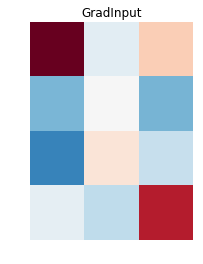

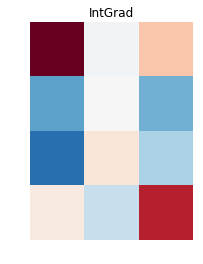

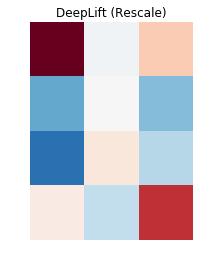

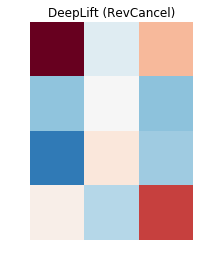

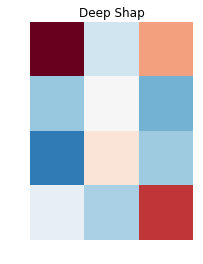

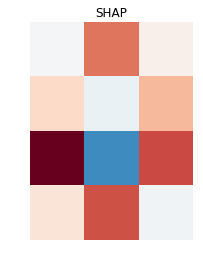

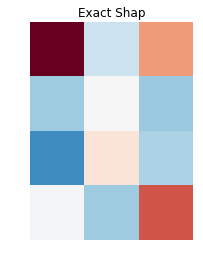

In [10]:
# Plot attributions
from utils import plot, plt
%matplotlib inline
idx = 3
plot(a_gradin[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('GradInput')
plt.figure()
plot(a_intgrad[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('IntGrad')
plt.figure()
plot(a_res[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('DeepLift (Rescale)')
#plt.figure()
#plot((a_linear)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Linear')
plt.figure()
plot(a_rc[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('DeepLift (RevCancel)')
plt.figure()
plot((a_shap)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Deep Shap')
plt.figure()
plot((a_shaplud)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('SHAP')
plt.figure()
plot((a_exact)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Exact Shap')


        
        


Diff with SHAP  11.208583570636812
Diff with DeepShap  0.959495513682824
Diff with DeepLift  0.6235568686235241
Diff with DeepLift (Rescale)  12.949478121350362
Diff with Int Gradients  13.640847481262517
Diff with GradInput  46.817406681288425
Pearson with SHAP  0.17010489510489513
Pearson with DeepShap  0.9414335664335667
Pearson with DeepLift  0.9405594405594406
Pearson with DeepLift (rescale) 0.9005244755244757
Pearson with Int Gradients  0.8993006993006996
Pearson with GradInput  0.7445804195804197


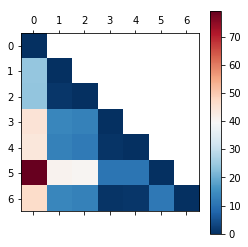

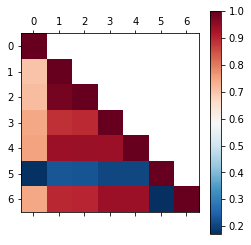

In [13]:
methods = [a_gradin, a_intgrad, a_res, a_rc, a_shap, a_shaplud, a_exact]
confusion = np.zeros((len(methods), len(methods)))
confusion[:] = np.nan
confusion_r = np.zeros((len(methods), len(methods)))
confusion_r[:] = np.nan

n = a_gradin.shape[0]
for i, m1 in enumerate(methods):
    for j, m2 in enumerate(methods):
        if i >= j:
            m1 = m1.reshape(n, -1)
            m2 = m2.reshape(n, -1)
            confusion[i][j] = ((m1-m2)**2).mean()
            confusion_r[i][j] = np.mean([scipy.stats.spearmanr(x, y)[0] for x,y in zip(m1, m2)])
plt.figure()
plt.matshow(confusion, cmap='RdBu_r')
plt.colorbar()
plt.figure()
plt.matshow(confusion_r, cmap='RdBu_r')
plt.colorbar()
print ('Diff with SHAP ', confusion[-1][-2])
print ('Diff with DeepShap ', confusion[-1][-3])
print ('Diff with DeepLift ', confusion[-1][-4])
print ('Diff with DeepLift (Rescale) ', confusion[-1][-5])
print ('Diff with Int Gradients ', confusion[-1][-6])
print ('Diff with GradInput ', confusion[-1][-7])

print ('Pearson with SHAP ', confusion_r[-1][-2])
print ('Pearson with DeepShap ', confusion_r[-1][-3])
print ('Pearson with DeepLift ', confusion_r[-1][-4])
print ('Pearson with DeepLift (rescale)', confusion_r[-1][-5])
print ('Pearson with Int Gradients ', confusion_r[-1][-6])
print ('Pearson with GradInput ', confusion_r[-1][-7])

In [16]:
from deepexplain.tensorflow.accuracy_robustness import run_robustness_test
original_maps = [a_gradin, a_intgrad, a_res, a_rc, a_shap, a_exact, a_shaplud]
names = ['GradInput', 'IntGrad', 'DeepLift (Recale)', 'DeepLift (RevCanc)', 'ApprShapley', 'Shapley', 'SHAP']
run_robustness_test(fModel, xs, ys, original_maps, names, 'Test', 1,
                        result_path='.', mode='prediction', reduce_dim=None)



Running robustness test...
Storing robustness results...
Done


In [15]:
from deepexplain.tensorflow.sensitivityn import run_sensitivity_test
run_sensitivity_test(fModel, xs, ys, original_maps, names, 'Test',
                        result_path='.', number_of_samples=1000)


NameError: name 'original_maps' is not defined